In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
!pip install wget
import wget
from tqdm import tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9f52bd5832caad0c98e730179afce4ad9bf624370b777663e08cdaf7fe69ae5a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
#Get the dataset

url = "https://raw.githubusercontent.com/google/madi/master/src/madi/datasets/data/anomaly_detection_sample_1577622599.csv"
wget.download(url, 'data.csv')

'data.csv'

In [ ]:
# Read the Dataset
df = pd.read_csv("/content/data.csv")

In [ ]:
df

,Unnamed: 0,data:zone_air_heating_temperature_setpoint,data:zone_air_temperature_sensor,data:zone_air_cooling_temperature_setpoint,data:supply_air_flowrate_sensor,data:supply_air_damper_percentage_command,data:supply_air_flowrate_setpoint,dow,hod,class_label
0,0,294.259259,296.037037,297.037037,0.044528,47.265250,0.037756,0,17,1
1,1,294.259259,294.925926,297.037037,0.203740,4.489845,0.188779,0,17,1
2,2,294.259259,296.648148,297.037037,0.036790,20.409615,0.035396,0,17,1
3,3,294.259259,296.425926,297.037037,0.154288,37.755330,0.151023,0,17,1
4,4,294.259259,296.092593,297.037037,0.178737,16.167740,0.169901,0,17,1
...,...,...,...,...,...,...,...,...,...,...
60420,60420,294.259259,295.537037,297.037037,0.411444,15.416842,0.365759,0,17,1
60421,60421,294.259259,296.259259,297.037037,0.033899,69.468780,0.033036,0,17,1
60422,60422,294.259259,295.148148,297.037037,0.213805,18.445625,0.198218,0,17,1
60423,60423,294.259259,295.203704,296.481481,0.074233,21.684418,0.068432,0,17,1


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Input, LSTM
from tensorflow.keras.models import Model, Sequential

# Building the GAN
class TabularGAN:
    def __init__(self, input_dim, noise_dim):
        self.input_dim = input_dim
        self.noise_dim = noise_dim                        # Latent vector dim
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan()

    # Defining the Generator
    def build_generator(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.noise_dim))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.input_dim, activation='sigmoid'))
        return model

    # Defining the Discriminator
    def build_discriminator(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.input_dim))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # Building the GAN model
    def build_gan(self):
        self.discriminator.trainable = False
        z = Input(shape=(self.noise_dim,))
        generated_data = self.generator(z)
        validity = self.discriminator(generated_data)
        gan = Model(z, validity)
        gan.compile(loss='binary_crossentropy', optimizer='adam')
        return gan

    # Defining the Training loop for the GAN
    def train(self, data, epochs, batch_size):
        valid = tf.ones((batch_size, 1))
        fake = tf.zeros((batch_size, 1))

        d_losses = []
        g_losses = []

        for epoch in range(epochs):
            # Training discriminator
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]
            noise = tf.random.normal((batch_size, self.noise_dim))
            generated_data = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(real_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training generator
            noise = tf.random.normal((batch_size, self.noise_dim))
            g_loss = self.gan.train_on_batch(noise, valid)

            d_losses.append(d_loss[0])  # Save D loss
            g_losses.append(g_loss)     # Save G loss

            print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        return g_losses, d_losses

    # Generate a synthetic sample closes to the given sample with a Earlystopping
    def generate_sample_close_to(self, x, num_iterations=1000, learning_rate=0.01, patience=50, min_delta=1e-5):
    # Create a variable to hold the noise vector
      noise = tf.Variable(tf.random.normal((1, self.noise_dim)))

      best_loss = float('inf')
      patience_counter = 0

      for _ in range(num_iterations):
          with tf.GradientTape() as tape:
              generated_data = self.generator(noise)
              loss = tf.reduce_mean(tf.square(generated_data - x))

          # Early stopping logic
          if (best_loss - loss) < min_delta:
              patience_counter += 1
          else:
              patience_counter = 0
              best_loss = loss

          if patience_counter >= patience:
              break

          # Compute the gradients of the loss with respect to the noise
          gradients = tape.gradient(loss, noise)

          # Update the noise vector using gradient ascent
          noise.assign_add(learning_rate * gradients)

      return noise.numpy()





In [ ]:
# Get data on only one class
df_single_class = df[df['class_label'] == 1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()   # Scaler to Normalize Data
scaled_df = pd.DataFrame(scaler.fit_transform(df_single_class), columns=df.columns)

# Select only the value without the header
data = scaled_df.values

# Assuming data has shape (n_samples, n_features)
input_dim = data.shape[1]
noise_dim = 100

# Train the GAN
gan = TabularGAN(input_dim, noise_dim)
his = gan.train(data, epochs=1000, batch_size=32)





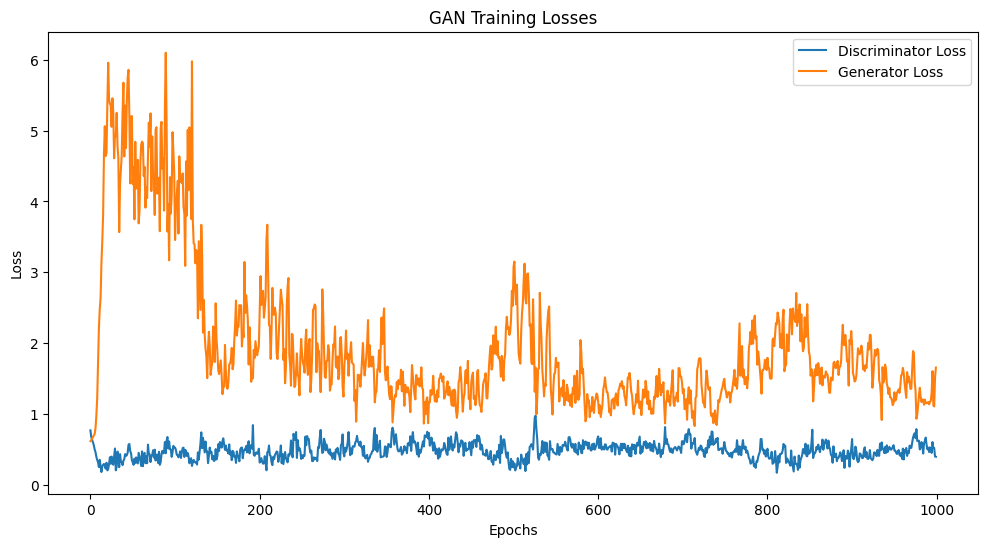

In [ ]:
import matplotlib.pyplot as plt


# Plot the Train Losses
plt.figure(figsize=(12, 6))
plt.plot(his[1], label="Discriminator Loss")
plt.plot(his[0], label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.show()

In [ ]:
ana_sample =  scaler.fit_transform(df[df['class_label'] == 0].head(1))    # Get 1 Anomaly sample for test
nor_sample = scaler.fit_transform(df[df['class_label'] == 1].head(1))     # Get 1 Normal sample for test

# Get the noise vector that generates a sample closes to the original sample. Compare the samples and get anomaly score (MSE)
optimal_noise = gan.generate_sample_close_to(ana_sample, num_iterations=500, learning_rate=0.1)
generated_sample = gan.generator(optimal_noise)
mse = np.mean(np.square(generated_sample - ana_sample))
print(mse)

# Get the noise vector that generates a sample closes to the original sample. Compare the samples and get anomaly score (MSE)
optimal_noise = gan.generate_sample_close_to(nor_sample, num_iterations=500, learning_rate=0.1)
generated_sample = gan.generator(optimal_noise)
mse = np.mean(np.square(generated_sample - nor_sample))
print(mse)

0.42505795
0.34029698


In [ ]:
# No of sample to test
N = 100

In [ ]:
# Test on 100 Anomaly Samples
ana_sample_arr = []
arr = []
for i in tqdm(range(N)):
  ana_sample =  scaler.fit_transform(np.array(df[df['class_label'] == 0].iloc[i]).reshape(-1, 1))
  optimal_noise = gan.generate_sample_close_to(ana_sample, num_iterations=1000, learning_rate=0.001)
  generated_sample = gan.generator(optimal_noise)
  mse = np.mean(np.square(generated_sample - ana_sample))
  ana_sample_arr.append(mse)

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


In [ ]:
# Test on 100 Non-Anomaly Samples
nor_sample_arr = []
arr = []
for i in tqdm(range(N)):
  ana_sample =  scaler.fit_transform(np.array(df[df['class_label'] == 1].iloc[i]).reshape(-1, 1))
  optimal_noise = gan.generate_sample_close_to(ana_sample, num_iterations=1000, learning_rate=0.001)
  generated_sample = gan.generator(optimal_noise)
  mse = np.mean(np.square(generated_sample - ana_sample))
  nor_sample_arr.append(mse)

 94%|█████████▍| 94/100 [01:13<00:04,  1.35it/s]

In [ ]:
real_labels = ([0] * N) + ([1] * N)
thresh = 0.5

In [ ]:
import seaborn as sns


# Plot the distributions of the anomaly scores for Anomalies and Non-Anomalies
sns.kdeplot(ana_sample_arr, shade=True, color="blue", label="Anomalies")  # 'label' will be used for the legend
sns.kdeplot(nor_sample_arr, shade=True, color="red", label="Non-Anomalies")

plt.title("Density Distribution of Two Datasets")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()